Importing all libraries required

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split
import cv2

To enable the GPU 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

Loading the data and viewing smaples

torch.Size([64, 64, 1]) 9


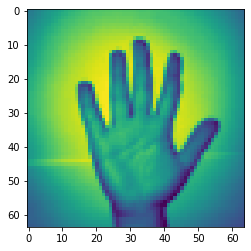

In [ ]:
X=np.load("X.npy").reshape(-1,64,64,1)
Y=np.load("Y.npy")
labels=np.argmax(Y,axis=1)
X=torch.from_numpy(X)
labels=torch.from_numpy(labels)
K=[]
for i in range(len(labels)):
    K.append([X[i],labels[i].item()])
X_train, X_test, Y_train, Y_test= train_test_split(K, labels, test_size=0.2,shuffle=True, stratify=labels, random_state=42)
im,lab=X_train[0]
plt.imshow(im.reshape(64,-1))
print(im.shape,lab)

Loading the data into DataLoader to be divided into minibatches:

In [ ]:
batch_size=128
trainer=DataLoader(K, batch_size, shuffle=True, num_workers=2, pin_memory=True)
tester=DataLoader(K, batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(trainer, device)
test_dl = DeviceDataLoader(tester, device)


Defining functions to train and validate corresponding models

In [ ]:
def fit(epochs, lr, model, train_loader, test_loader, opt_func):
    data = []
    optimizer = opt_func(model.parameters(), lr)
    c=0
    opt_test=[]
    for epoch in range(epochs):
        c=c+1
        train_losses = []
        test_losses=[]
        Train_acc=[]
        Test_acc=[]

        result=[0,0,0,0]
        for batch in train_loader:
          images,labels=batch
          out1=model(images.permute(0,3,1,2))
          loss = F.cross_entropy(out1, labels)
          train_losses.append(loss)
          k=loss.item()
          #print(loss.item())
          if(c<13):
            opt_test.append(k)
            
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          with torch.no_grad():
            acc1=accuracy(out1,labels)
          Train_acc.append(acc1)
        with torch.no_grad():
          for batch in test_loader:
            images,labels = batch
            out2=model(images.permute(0,3,1,2))
            loss2 = F.cross_entropy(out2, labels)
            test_losses.append(loss2)
            acc2=accuracy(out2,labels)
            Test_acc.append(acc2)
        result[0] = torch.stack(train_losses).mean().item()
        result[1] = torch.stack(test_losses).mean().item()
        result[2] = torch.stack(Train_acc).mean().item()
        result[3] = torch.stack(Test_acc).mean().item()
        if(c%10==0):
          print(c,result)
        data.append(result)
    return (data, opt_test)
def accuracy(outputs, labels):
    Probab, predictions = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

In [ ]:
def plot_accuracies(plot_data):
    accuracy1 = [x[2] for x in plot_data]
    accuracy2 = [x[3] for x in plot_data]
    plt.plot(accuracy1, '-bx')
    plt.plot(accuracy2, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    plt.show()
def plot_losses(plot_data):
    train_losses = [x[0] for x in plot_data]
    test_losses = [x[1] for x in plot_data]
    plt.plot(train_losses, '-bx')
    plt.plot(test_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show();
def plot_opt(plot_data):
    plt.plot(np.asarray(plot_data), '-x')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of iterations');
    plt.show()

Defining different models using different architectures:

Model for Logistic Regression: 

In [ ]:
class L_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(64*64, 10))
    def forward(self, xb):
        return self.network(xb)

Model for Linear Neural Network:

In [ ]:
class Linear_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(64*64, 10))
    def forward(self, xb):
        return self.network(xb)

Model for Neural Network with ReLU Non-Linearity:

In [ ]:
class ANN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(64*64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
    def forward(self, xb):
        return self.network(xb)

Model for classification using CNN Architecture 1:

In [ ]:
class CNN_Model_01(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(), 
            nn.Linear(64*16*16, 10),
            nn.ReLU(),
            nn.Linear(10, 10))
    def forward(self, xb):
        return self.network(xb)

Model for classification using CNN Architecture 2:

In [ ]:
class CNN_Model_02(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(), 
            nn.Linear(64*16*16, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10))
    def forward(self, xb):
        return self.network(xb)

Model for classification using CNN Architecture 3:

In [ ]:
class CNN_Model_03(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Flatten(), 
            nn.Linear(32*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
    def forward(self, xb):
        return self.network(xb)

Model for classification using CNN Architecture 4:

In [ ]:
class CNN_Model_04(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Flatten(), 
            nn.Linear(4*1*1, 128),
            nn.ReLU(),
            nn.Linear(128, 250),
            nn.ReLU(),
            nn.Linear(250, 250),
            nn.ReLU(),
            nn.Linear(250, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
    def forward(self, xb):
        return self.network(xb)

Defining Number of iterations, learning rate and optimization functions

In [ ]:
num_epochs = 100
opt_func = torch.optim.Adam
opt_func_02 = torch.optim.SGD
lr = 0.001

Defining different objects for different models, two for each architecture, for using different optimizers:

In [ ]:
LR = to_device(L_Regression(), device)
Linear = to_device(Linear_Model(), device)
ANN = to_device(ANN_Model(), device)
CNN_01 = to_device(CNN_Model_01(), device)
CNN_02 = to_device(CNN_Model_02(), device)
CNN_03 = to_device(CNN_Model_03(), device)
CNN_04 = to_device(CNN_Model_04(), device)
LR_02 = to_device(L_Regression(), device)
Linear_02 = to_device(Linear_Model(), device)
ANN_02 = to_device(ANN_Model(), device)
CNN_01_02 = to_device(CNN_Model_01(), device)
CNN_02_02 = to_device(CNN_Model_02(), device)
CNN_03_02 = to_device(CNN_Model_03(), device)
CNN_04_02 = to_device(CNN_Model_04(), device)

Final Performances::

Result of Logistic Regression using Adam:

10 [1.4180737733840942, 1.3311811685562134, 0.584099292755127, 0.6695115566253662]
20 [1.0799448490142822, 1.062430500984192, 0.6802783012390137, 0.7175682783126831]
30 [0.9080662131309509, 0.9697929620742798, 0.748490035533905, 0.7161896228790283]
40 [0.8048791289329529, 0.8118710517883301, 0.7708771228790283, 0.7703518867492676]
50 [0.7993299961090088, 0.8162657618522644, 0.7459952235221863, 0.7314206957817078]
60 [0.7011510133743286, 0.7804986238479614, 0.7995010614395142, 0.7576812505722046]
70 [0.6720597743988037, 0.7539991736412048, 0.8046218752861023, 0.7677258253097534]
80 [0.6176362633705139, 0.6152912974357605, 0.8271402716636658, 0.827599823474884]
90 [0.5829529762268066, 0.601406991481781, 0.8421743512153625, 0.8220850825309753]
100 [0.5866098999977112, 0.6114466190338135, 0.8136817216873169, 0.806525707244873]


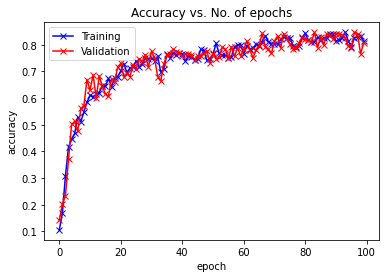

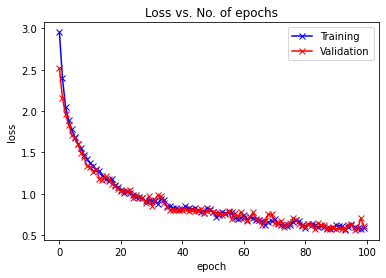

In [ ]:
LR_Result_Adam,_ = fit(num_epochs, lr, LR, train_dl, test_dl, opt_func)
plot_accuracies(LR_Result_Adam)
plot_losses(LR_Result_Adam)

Result of Linear Model using Adam:

10 [1.375853180885315, 1.5219720602035522, 0.6155462265014648, 0.4877888858318329]
20 [1.0530072450637817, 1.015631914138794, 0.6873687505722046, 0.7111344337463379]
30 [0.9292126893997192, 0.891829252243042, 0.7209165096282959, 0.7333902716636658]
40 [0.8410516381263733, 0.8517019748687744, 0.7419248819351196, 0.7204569578170776]
50 [0.7673170566558838, 0.7664360404014587, 0.7796743512153625, 0.7566307783126831]
60 [0.697831392288208, 0.70551598072052, 0.7944459319114685, 0.7949054837226868]
70 [0.6590584516525269, 0.6769364476203918, 0.8105304837226868, 0.8116465210914612]
80 [0.6514758467674255, 0.6438762545585632, 0.809151828289032, 0.8209690451622009]
90 [0.5911332964897156, 0.6094809174537659, 0.8218881487846375, 0.8243829011917114]
100 [0.5657106637954712, 0.5446100234985352, 0.8385635614395142, 0.8399422764778137]


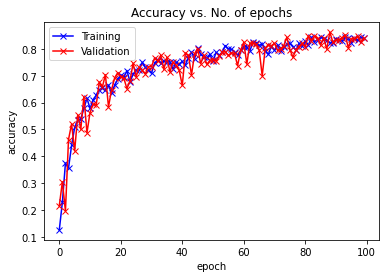

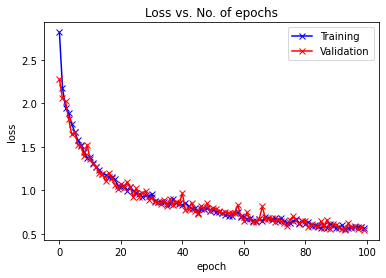

In [ ]:
Linear_Result_Adam,_ = fit(num_epochs, lr, Linear, train_dl, test_dl, opt_func)
plot_accuracies(Linear_Result_Adam)
plot_losses(Linear_Result_Adam)

Result of Non Linear Deep Network using Adam:

10 [1.3452374935150146, 1.3109662532806396, 0.5508140921592712, 0.5625]
20 [0.9538909792900085, 0.8942129015922546, 0.6660320162773132, 0.7198660969734192]
30 [0.7075612545013428, 0.7803611755371094, 0.7839417457580566, 0.7506565451622009]
40 [0.7063842415809631, 0.639259934425354, 0.7723870873451233, 0.7985162734985352]
50 [0.5456722974777222, 0.5685707330703735, 0.8251706957817078, 0.8237919807434082]
60 [0.5694905519485474, 0.9303145408630371, 0.8150603771209717, 0.6706275939941406]
70 [0.5160125494003296, 0.4507792890071869, 0.841255247592926, 0.8528099060058594]
80 [0.45881474018096924, 0.42832642793655396, 0.8471638560295105, 0.8675814270973206]
90 [0.4234706163406372, 0.41796591877937317, 0.8713235259056091, 0.8629858493804932]
100 [0.35810503363609314, 0.3747262954711914, 0.8878676295280457, 0.8840599060058594]


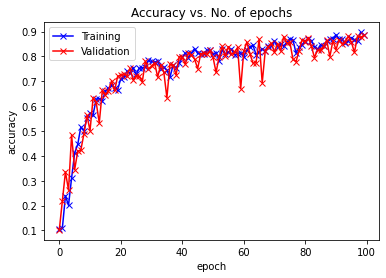

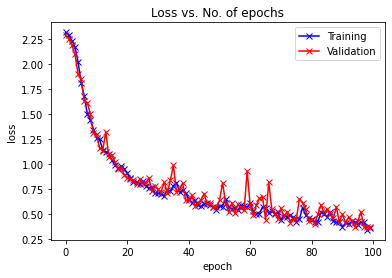

In [ ]:
ANN_Result_Adam,_ = fit(num_epochs, lr, ANN, train_dl, test_dl, opt_func)
plot_accuracies(ANN_Result_Adam)
plot_losses(ANN_Result_Adam)

Result of CNN Architecture 1 using Adam:

10 [2.3074238300323486, 2.3092148303985596, 0.09749212116003036, 0.09375]
20 [2.304948329925537, 2.305311918258667, 0.09749212116003036, 0.09375]
30 [2.303236246109009, 2.303967237472534, 0.10307247191667557, 0.09466911852359772]
40 [2.3027541637420654, 2.3026082515716553, 0.09841123968362808, 0.09841123968362808]
50 [2.3024699687957764, 2.302351236343384, 0.09841123968362808, 0.10215336084365845]
60 [2.302521228790283, 2.3026299476623535, 0.09841123968362808, 0.10589548200368881]
70 [2.302678108215332, 2.3028411865234375, 0.10215336084365845, 0.09841123968362808]
80 [2.302671432495117, 2.302724599838257, 0.09841123968362808, 0.09841123968362808]
90 [2.3026907444000244, 2.3025686740875244, 0.09512867778539658, 0.10635504126548767]
100 [2.3026342391967773, 2.3029000759124756, 0.10261291265487671, 0.09512867778539658]


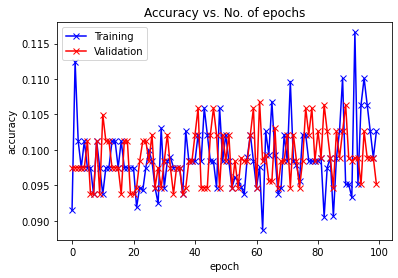

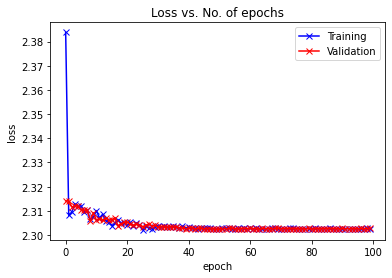

In [ ]:
CNN_01_Result_Adam,_ = fit(num_epochs, lr, CNN_01, train_dl, test_dl, opt_func)
plot_accuracies(CNN_01_Result_Adam)
plot_losses(CNN_01_Result_Adam)

Revised Learning rate for CNN Architecture 1 using ADAM

10 [2.3032350540161133, 2.3024404048919678, 0.09841123968362808, 0.09841123968362808]
20 [2.30314040184021, 2.3025221824645996, 0.09466911852359772, 0.10215336084365845]
30 [2.302858352661133, 2.3030691146850586, 0.09841123968362808, 0.09466911852359772]
40 [2.3026375770568848, 2.302877187728882, 0.10215336084365845, 0.10589548200368881]
50 [2.302410840988159, 2.3032054901123047, 0.09841123968362808, 0.09841123968362808]
60 [2.3027679920196533, 2.3025355339050293, 0.09841123968362808, 0.10963760316371918]
70 [2.302945375442505, 2.302522897720337, 0.09841123968362808, 0.10215336084365845]
80 [2.302219867706299, 2.3028054237365723, 0.10963760316371918, 0.09841123968362808]
90 [2.3026342391967773, 2.3025593757629395, 0.10215336084365845, 0.10215336084365845]
100 [2.3024978637695312, 2.3023672103881836, 0.10215336084365845, 0.10215336084365845]


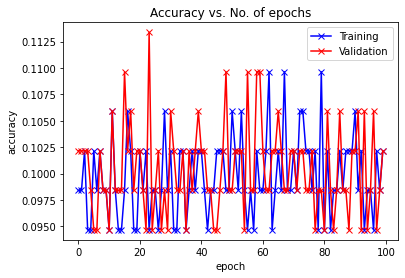

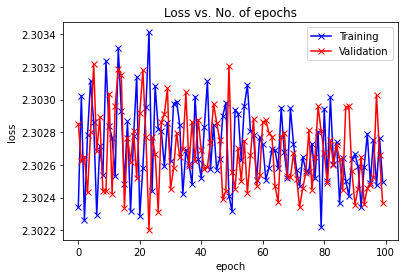

In [ ]:
CNN_01_Result_Adam,_ = fit(num_epochs, 0.0001, CNN_01, train_dl, test_dl, opt_func)
plot_accuracies(CNN_01_Result_Adam)
plot_losses(CNN_01_Result_Adam)

Result of CNN Architecture 2 using Adam:

10 [0.3196913003921509, 0.3037422299385071, 0.8952205777168274, 0.9015887975692749]
20 [0.04078817367553711, 0.044522978365421295, 0.9926470518112183, 0.9866728186607361]
30 [0.006730968598276377, 0.005435367580503225, 0.9995404481887817, 1.0]
40 [0.0008388282149098814, 0.000778036133851856, 1.0, 1.0]
50 [0.0004663810832425952, 0.0004513845487963408, 1.0, 1.0]
60 [0.00031799072166904807, 0.0002969149500131607, 1.0, 1.0]
70 [0.000236077859881334, 0.00022111364523880184, 1.0, 1.0]
80 [0.0001761714374879375, 0.00017316760204266757, 1.0, 1.0]
90 [0.00012745949788950384, 0.0001385156938340515, 1.0, 1.0]
100 [0.00010000724432757124, 9.937628055922687e-05, 1.0, 1.0]


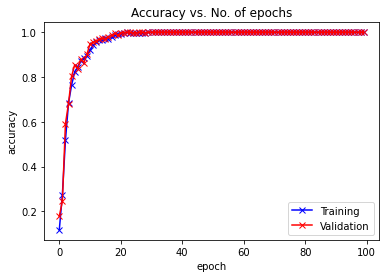

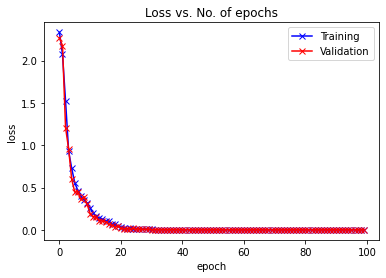

In [ ]:
CNN_02_Result_Adam,_ = fit(num_epochs, lr, CNN_02, train_dl, test_dl, opt_func)
plot_accuracies(CNN_02_Result_Adam)
plot_losses(CNN_02_Result_Adam)

Result of CNN Architecture 3 using Adam:

10 [0.0981760323047638, 0.10126511007547379, 0.9673056602478027, 0.9673713445663452]
20 [0.00572372367605567, 0.0020458793733268976, 0.9995404481887817, 0.9995404481887817]
30 [0.0002329328708583489, 0.00022348952188622206, 1.0, 1.0]
40 [0.0001439868356101215, 0.00012160315964138135, 1.0, 1.0]
50 [8.76731937751174e-05, 8.554583473596722e-05, 1.0, 1.0]
60 [5.861570389242843e-05, 5.645637065754272e-05, 1.0, 1.0]
70 [4.387438821140677e-05, 4.468224142328836e-05, 1.0, 1.0]
80 [3.5696841223398224e-05, 3.342114723636769e-05, 1.0, 1.0]
90 [2.662035149114672e-05, 2.544092967582401e-05, 1.0, 1.0]
100 [2.1452533474075608e-05, 2.126922299794387e-05, 1.0, 1.0]


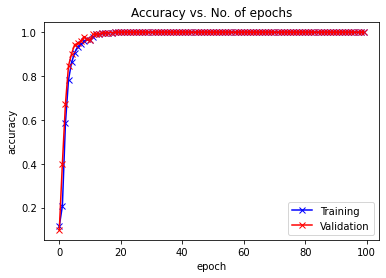

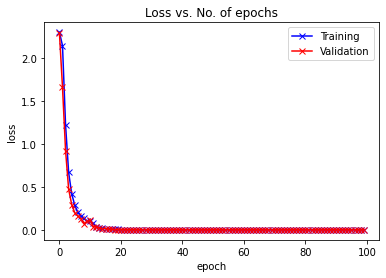

In [ ]:
CNN_03_Result_Adam,data1 = fit(num_epochs, lr, CNN_03, train_dl, test_dl, opt_func)
plot_accuracies(CNN_03_Result_Adam)
plot_losses(CNN_03_Result_Adam)

Result of CNN Architecture 4 using Adam:

10 [2.133396863937378, 1.9840797185897827, 0.19045431911945343, 0.23043593764305115]
20 [0.2814958095550537, 0.22112834453582764, 0.9005383253097534, 0.9231224060058594]
30 [0.026775430887937546, 0.017124738544225693, 0.9926470518112183, 0.9958639740943909]
40 [0.04170672968029976, 0.033543188124895096, 0.9875919222831726, 0.9861475825309753]
50 [0.027717942371964455, 0.05019857734441757, 0.9917279481887817, 0.9820115566253662]
60 [0.0011384370736777782, 0.00034484235220588744, 1.0, 1.0]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10949b2440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f10949b2440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

70 [7.540654769400135e-05, 7.594148337375373e-05, 1.0, 1.0]
80 [4.0539114706916735e-05, 3.796163946390152e-05, 1.0, 1.0]
90 [2.5575694962753914e-05, 2.2596237613470294e-05, 1.0, 1.0]
100 [1.4401481166714802e-05, 1.3952142580819782e-05, 1.0, 1.0]


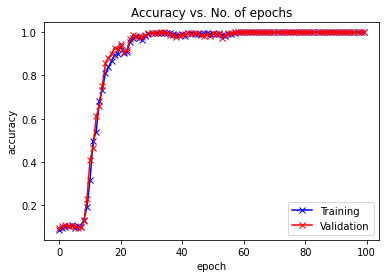

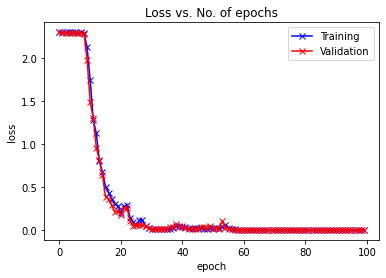

In [ ]:
CNN_04_Result_Adam,_ = fit(num_epochs, lr, CNN_04, train_dl, test_dl, opt_func)
plot_accuracies(CNN_04_Result_Adam)
plot_losses(CNN_04_Result_Adam)

Result of Logistic Regression using SGD

10 [2.216243028640747, 2.2080154418945312, 0.2676602005958557, 0.29267334938049316]
20 [2.1246681213378906, 2.1142075061798096, 0.4360556900501251, 0.4186580777168274]
30 [2.0433387756347656, 2.0519859790802, 0.5238970518112183, 0.38340336084365845]
40 [1.9678726196289062, 1.9638941287994385, 0.5667672753334045, 0.5699841976165771]
50 [1.900635838508606, 1.903605341911316, 0.5790441036224365, 0.504989504814148]
60 [1.8376742601394653, 1.8418323993682861, 0.6146271228790283, 0.5781906247138977]
70 [1.781867504119873, 1.7973164319992065, 0.6181066036224365, 0.5372899174690247]
80 [1.730247974395752, 1.7390143871307373, 0.6288734078407288, 0.6144957542419434]
90 [1.688913345336914, 1.683599829673767, 0.6263786554336548, 0.6136422753334045]
100 [1.6399528980255127, 1.6364344358444214, 0.6551339030265808, 0.6142331957817078]


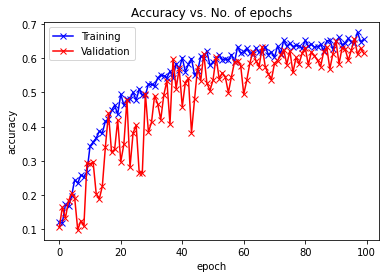

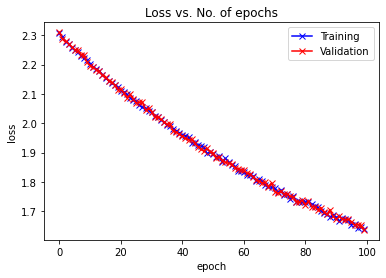

In [ ]:
LR_Result_SGD,_ = fit(num_epochs, lr, LR_02, train_dl, test_dl, opt_func_02)
plot_accuracies(LR_Result_SGD)
plot_losses(LR_Result_SGD)

Result of Linear Neural Network using SGD

10 [2.1987030506134033, 2.1995832920074463, 0.3248424530029297, 0.2868959903717041]
20 [2.111748456954956, 2.1133203506469727, 0.4544380307197571, 0.40145745873451233]
30 [2.0306665897369385, 2.041801929473877, 0.5474658012390137, 0.3044905364513397]
40 [1.965195655822754, 1.9547260999679565, 0.5540966987609863, 0.5681459903717041]
50 [1.8969756364822388, 1.890539288520813, 0.5914521813392639, 0.5602678656578064]
60 [1.8339741230010986, 1.837646722793579, 0.625, 0.561974823474884]
70 [1.7708083391189575, 1.7790369987487793, 0.6321559548377991, 0.5672268867492676]
80 [1.7269906997680664, 1.7253034114837646, 0.6485031247138977, 0.5676864385604858]
90 [1.6840230226516724, 1.669049620628357, 0.6586134433746338, 0.6206013560295105]
100 [1.6368740797042847, 1.6444296836853027, 0.6715466976165771, 0.5570509433746338]


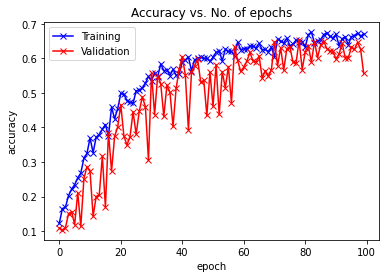

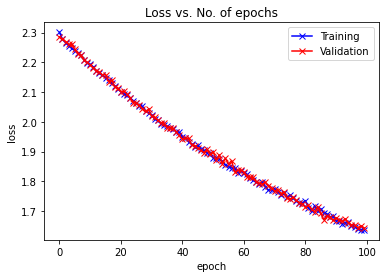

In [ ]:
Linear_Result_SGD,_ = fit(num_epochs, lr, Linear_02, train_dl, test_dl, opt_func_02)
plot_accuracies(Linear_Result_SGD)
plot_losses(Linear_Result_SGD)

Result of ANN using SGD

10 [2.296464204788208, 2.297513961791992, 0.15598739683628082, 0.13005514442920685]
20 [2.2933907508850098, 2.293097972869873, 0.19051994383335114, 0.209690123796463]
30 [2.288179636001587, 2.2889256477355957, 0.24153098464012146, 0.24743960797786713]
40 [2.28489351272583, 2.28364896774292, 0.23634453117847443, 0.2586003243923187]
50 [2.2798705101013184, 2.2799224853515625, 0.29864761233329773, 0.2681853771209717]
60 [2.2755072116851807, 2.2742319107055664, 0.30961135029792786, 0.3314732015132904]
70 [2.269361734390259, 2.269120216369629, 0.299369752407074, 0.3013392984867096]
80 [2.2638211250305176, 2.263995885848999, 0.3312106132507324, 0.3338366746902466]
90 [2.2578723430633545, 2.2558908462524414, 0.3384978771209717, 0.3771665096282959]
100 [2.250155210494995, 2.2500364780426025, 0.4208902418613434, 0.4420955777168274]


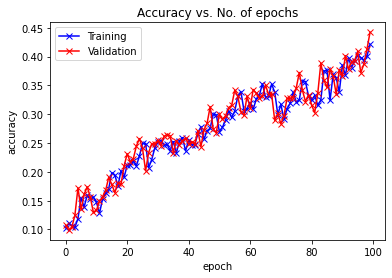

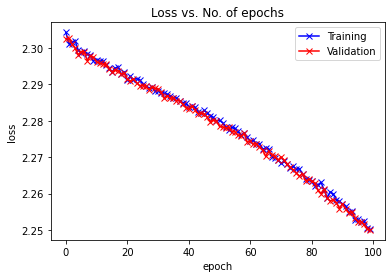

In [ ]:
ANN_Result_SGD,_ = fit(num_epochs, lr, ANN_02, train_dl, test_dl, opt_func_02)
plot_accuracies(ANN_Result_SGD)
plot_losses(ANN_Result_SGD)

Result of CNN Architecture 1 using SGD

10 [2.308992624282837, 2.307298421859741, 0.09887079894542694, 0.09887079894542694]
20 [2.306368827819824, 2.3053195476531982, 0.09887079894542694, 0.09512867778539658]
30 [2.3031864166259766, 2.2994611263275146, 0.09887079894542694, 0.10261291265487671]
40 [2.2987570762634277, 2.298616409301758, 0.09512867778539658, 0.09512867778539658]
50 [2.2928690910339355, 2.2898709774017334, 0.09512867778539658, 0.10261291265487671]
60 [2.283609628677368, 2.2841796875, 0.10261291265487671, 0.10261291265487671]
70 [2.275989532470703, 2.275343418121338, 0.09887079894542694, 0.09887079894542694]
80 [2.2646167278289795, 2.2650601863861084, 0.11784402281045914, 0.18960082530975342]
90 [2.24930477142334, 2.249664068222046, 0.17712710797786713, 0.248883917927742]
100 [2.227142810821533, 2.2280447483062744, 0.26404935121536255, 0.23194590210914612]


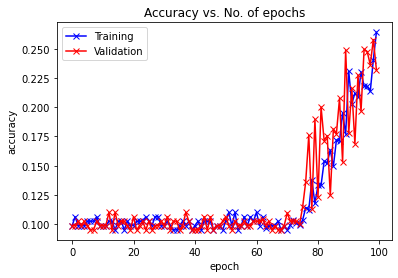

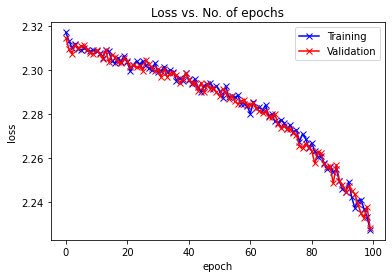

In [ ]:
CNN_01_Result_SGD,_ = fit(num_epochs, lr, CNN_01_02, train_dl, test_dl, opt_func_02)
plot_accuracies(CNN_01_Result_SGD)
plot_losses(CNN_01_Result_SGD)

Result of CNN ARchitecture 2 using SGD

10 [2.301417350769043, 2.3013813495635986, 0.1439732164144516, 0.11173844337463379]
20 [2.2988200187683105, 2.2982983589172363, 0.1172531470656395, 0.11219800263643265]
30 [2.2967147827148438, 2.2962722778320312, 0.13254989683628082, 0.1048450618982315]
40 [2.2939507961273193, 2.292759418487549, 0.14016544818878174, 0.17811186611652374]
50 [2.291189432144165, 2.289428949356079, 0.2086397111415863, 0.26280200481414795]
60 [2.286436080932617, 2.286259174346924, 0.20371586084365845, 0.25485819578170776]
70 [2.280282497406006, 2.281135320663452, 0.2853204011917114, 0.283744752407074]
80 [2.275176525115967, 2.2754316329956055, 0.3146665096282959, 0.3057379126548767]
90 [2.267108678817749, 2.2675986289978027, 0.36003151535987854, 0.3572084903717041]
100 [2.2578964233398438, 2.2564682960510254, 0.36009716987609863, 0.3761160671710968]


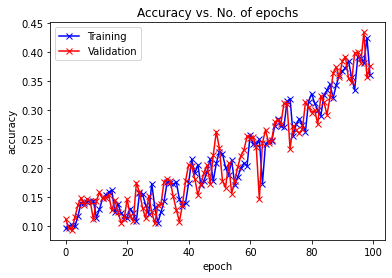

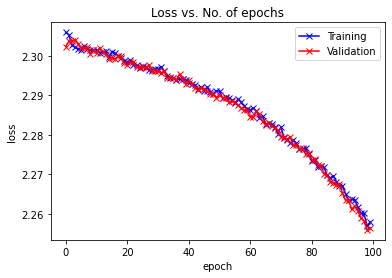

In [ ]:
CNN_02_Result_SGD,_ = fit(num_epochs, lr, CNN_02_02, train_dl, test_dl, opt_func_02)
plot_accuracies(CNN_02_Result_SGD)
plot_losses(CNN_02_Result_SGD)

Result of CNN ARchitecture 3 using SGD

10 [2.3037326335906982, 2.3041324615478516, 0.10215336084365845, 0.09466911852359772]
20 [2.3038926124572754, 2.302642822265625, 0.10215336084365845, 0.09841123968362808]
30 [2.3027756214141846, 2.303631067276001, 0.09841123968362808, 0.09841123968362808]
40 [2.3040287494659424, 2.3033010959625244, 0.10215336084365845, 0.10589548200368881]
50 [2.303464651107788, 2.30389404296875, 0.09841123968362808, 0.09841123968362808]
60 [2.3031396865844727, 2.302398204803467, 0.10589548200368881, 0.10215336084365845]
70 [2.3034560680389404, 2.303562879562378, 0.09466911852359772, 0.09841123968362808]
80 [2.3024795055389404, 2.302870750427246, 0.10589548200368881, 0.10589548200368881]
90 [2.3031375408172607, 2.301741600036621, 0.09466911852359772, 0.10963760316371918]
100 [2.3027164936065674, 2.3018548488616943, 0.10215336084365845, 0.10215336084365845]


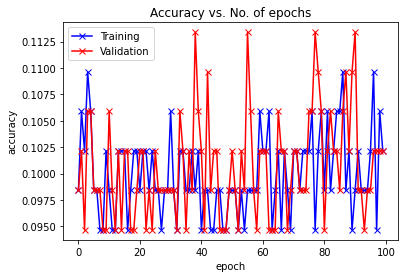

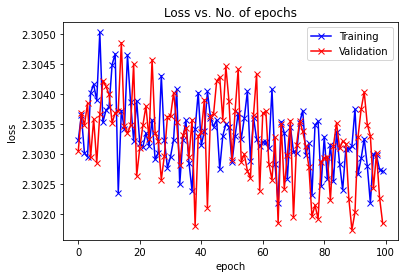

In [ ]:
CNN_03_Result_SGD, data2 = fit(num_epochs, lr, CNN_03_02, train_dl, test_dl, opt_func_02)
plot_accuracies(CNN_03_Result_SGD)
plot_losses(CNN_03_Result_SGD)

Result of CNN ARchitecture 4 using SGD

10 [2.30379581451416, 2.3036386966705322, 0.09841123968362808, 0.10215336084365845]
20 [2.303758144378662, 2.303107261657715, 0.10215336084365845, 0.10589548200368881]
30 [2.303232192993164, 2.303049087524414, 0.09466911852359772, 0.09466911852359772]
40 [2.303201913833618, 2.3027684688568115, 0.09841123968362808, 0.10215336084365845]
50 [2.3030543327331543, 2.303980827331543, 0.10589548200368881, 0.09466911852359772]
60 [2.302778482437134, 2.303067445755005, 0.10215336084365845, 0.09841123968362808]
70 [2.302755117416382, 2.30224347114563, 0.09841123968362808, 0.10589548200368881]
80 [2.303176164627075, 2.30367374420166, 0.09841123968362808, 0.09841123968362808]
90 [2.3031187057495117, 2.302934169769287, 0.09466911852359772, 0.09466911852359772]
100 [2.302927017211914, 2.3025894165039062, 0.10215336084365845, 0.09841123968362808]


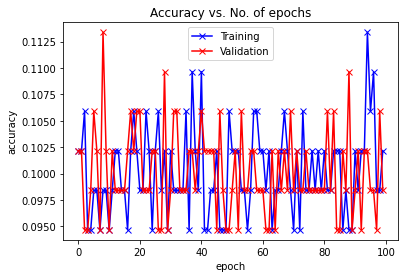

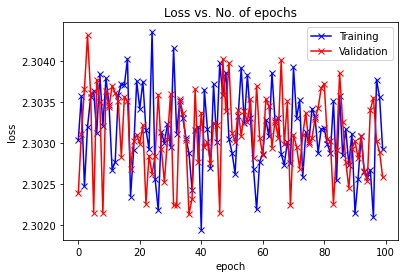

In [ ]:
CNN_04_Result_SGD,_ = fit(num_epochs, lr, CNN_04_02, train_dl, test_dl, opt_func_02)
plot_accuracies(CNN_04_Result_SGD)
plot_losses(CNN_04_Result_SGD)

Testing images from Webcam

To be run when using JuPyter Notebook (Press D for capturing image):

In [ ]:
capture=cv.VideoCapture(0)
while True:
    isTrue, frame=capture.read()
    grayFrame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    grayFrame=cv.resize(grayFrame, (64,64), interpolation=cv.INTER_AREA)
    cv.imshow('capture',frame)
    cv.imshow('capture2',grayFrame)
    img=np.asarray(grayFrame)
    if cv.waitKey(20) & 0xFF==ord('d'):
        break
capture.release()
cv.destroyAllWindows()

In [ ]:
# This code works fine for google colab

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

In [ ]:
im=cv2.imread('photo.jpg')
img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
img=np.asarray(cv2.resize(img_gray, (64,64), interpolation=cv2.INTER_AREA)).reshape(64,64,1)

In [ ]:
img1=torch.from_numpy(img)
batch=to_device(img1.unsqueeze(0),device)
with torch.no_grad():
  acc=CNN_03((batch.to(torch.float)).permute(0,3,1,2))
Map=[9, 0, 7, 6, 1, 8, 4, 3, 2, 5]
Prob, pred = torch.max(acc, dim=1)
print("The digit is",Map[pred.item()])

The digit is 5


Comparing ADAM and SGD losses

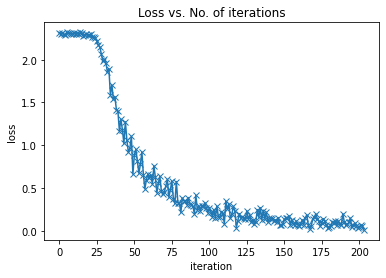

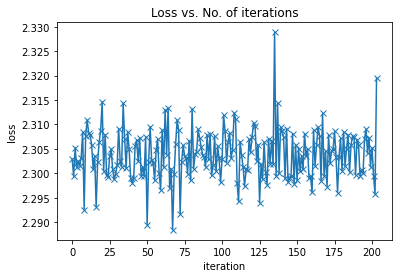

In [ ]:
plot_opt(data1)
plot_opt(data2)